## Code to run CorrCal with dish scatter

In [5]:
%run Functions.py

In [1]:
import numpy as np
import random
import h5py,time, matplotlib.pyplot as plt
from scipy.optimize import fmin_cg, minimize
from drift.core import manager
import corrcal
import sys
sys.path.insert(0,'/home/zahra/PIPELINE')
from hirax_transfer import core
import scipy as sp
from cora.util import hputil
from astropy.stats import gaussian_fwhm_to_sigma
from hirax_transfer.beams import separations
import healpy as hp
from cora.core import skysim
from cora.foreground import gaussianfg, galaxy
from cora.util import coord
from drift.core import visibility
sys.path.insert(0,'/home/zahra/hirax_tools/')
from hirax_tools import array_config
from LogCal_code import Bls_counts
from cora.foreground import poisson as ps
import concurrent.futures

Prod params file used to generate x and y antenna positions, assuming single feed for each antenna


In [8]:
m = manager.ProductManager.from_config('/home/zahra/PIPELINE/8by8_no_sims/prod_params_custom.yaml') 

t = m.telescope
Nfeeds,_= t.feedpositions.shape
Ndish = np.int(Nfeeds/2)
Nbls = np.int(Ndish*(Ndish-1)/2)

x = t.feedpositions[:,0][:Ndish] 
y = t.feedpositions[:,1][:Ndish]


Product directory: /home/zahra/PIPELINE/8by8_no_sims/bt_matrices


In [15]:
x = x + np.load('/home/zahra/corrcal2/random_pt1_x_64.npy')[:Ndish]
y = y + np.load('/home/zahra/corrcal2/random_pt1_y_64.npy')[:Ndish]

In [16]:
bl_arr_dish_indices, sum_counts, bl_counts = Bls_counts(m)
lims = np.append(0, sum_counts) #these are the edges of the redundant blocks

In [17]:
ant1 = bl_arr_dish_indices[:,0].astype(int)
ant2 = bl_arr_dish_indices[:,1].astype(int)

In [18]:
Frequency = 400. #MHz
Nside = 256
zenith = t.zenith

The Mu function follows the equation $\mu_n = \int S^n \frac{dN}{dS} dS$, with n=2 used for visibilities and n=3 for sky cov

I give details of generating the bright point source map (These are taken from cora - one of the Radio Cosmology packages). The functions below show that fluxes from a flux distribution are placed in random pixels, such that we can treat individual pixels as sources.

Please note that the next three cells are taken from cora and are not written by me

In [19]:
flux_min = 1.
flux_max = 10.

In [20]:
Map = getsky(Frequency, Nside, flux_min, flux_max)[0] # I save this array for each flux range that I consider so 
#that the source positions are the same for each run

Below is the function to generate the source vector. Ideally, when computing the per visibility response to each source for each baseline, I would consider each pixel in the HEALPix map. This takes about two hours to finish running, and scales up considerably with an increase in the number of bright sources. Thus, I only include the pixels that contribute to the visilities (i.e. include pixels that give non-zero visibilities). As a result, I multiply the map values and beammodel, and consider the pixels for which this product is larger than some value (set to $10^{-3}$ in the function below)

The visibilities due bright sources is then computed by summing over the per visibility response of each bright source, in the source vector, S, as shown below

In [21]:
src_total = np.load('src_total_6Aug_flux_1Jy_10Jy.npy')
Vis_bright_sources = np.load('Vis_bright_sources_6Aug_flux_1Jy_10Jy.npy')

Again, to speed up the code, I do not include each pixel of the HEALPix map when generating visibilities of unresolved, dim sources, with a Poisson distribution. I only include pixels where the beam is larger than $10^{-10}$, as demonstrated in the function below.

In [23]:
%store -r Vis_poisson

In [26]:
Vis_total = Vis_poisson + Vis_bright_sources

The redundant blocking that I use in the function below is the same as that used for the perfectly redundant case. 

In [27]:
%store -r vecs

True gains which we set to 1, so that the real and imaginary components correspond to the
amplitude and phase, respectively

In [9]:
gain = np.ones(Ndish)
sim_gains = np.ones(2*Ndish)
sim_gains[::2] = gain.real
sim_gains[1::2] = gain.imag

In [29]:
src_zeros = np.zeros(2*Nbls) # used if the source positions are unknown

In [66]:
v1=np.zeros(2*Nbls)
v1[0::2]=1
v2=np.zeros(2*Nbls)
v2[1::2]=1
vecs_redundant = np.vstack([v1,v2])*1.e3 # used for the redundant case in CorrCal

In [68]:
rec_gains = fit_gains(500, src_total, vecs, Vis_total)

         Current function value: 123828525520.524170
         Iterations: 8
         Function evaluations: 145
         Gradient evaluations: 133
         Current function value: 123828525520.524170
         Iterations: 8
         Function evaluations: 145
         Gradient evaluations: 133
         Current function value: 123828525520.524170
         Iterations: 8
         Function evaluations: 145
         Gradient evaluations: 133
         Current function value: 123828525520.524170
         Iterations: 8
         Function evaluations: 145
         Gradient evaluations: 133
         Current function value: 123828525520.524170
         Iterations: 8
         Function evaluations: 145
         Gradient evaluations: 133
[1.00015764 0.99985447 1.00008565 0.99973648 0.9997448  1.00062999
 0.99954346 0.99986532 1.00069045 1.00004118 1.00104474 1.00027647
 0.99968763 1.00115256 0.99993834 1.00042822 0.99991047 1.00106036
 1.00072264 1.00027743 0.99996977 1.00020111 1.00044237 1.00070479
 0

In [ ]:
std, mean = hist_rel_err_mean_std(results_arr, sim_gains[::2]) # To consider just the 
#amplitude, we take every second value

I loaded the results I had obtained for the mean and std dev of the gain amplitude error for 500 noise realisations, using both CorrCal and LogCal. These runs assume 314 bright sources between 1-10 Jy contribute to the visibilities. The sources are generated from the luminosity function (Di Matteo et al. 2012)

In [10]:
results_arr = np.load('amp_gains_CorrCal_perturbed_brightsources_1Jy_10Jy_314_sources_500_runs.npy')

In [11]:
logcal_results_arr = np.load('amp_gains_LogCal_perturbed_brightsources_1Jy_10Jy_314_sources_500_runs.npy')

In [12]:
std_logcal, mean_logcal = hist_rel_err_mean_std(np.exp(logcal_results_arr), sim_gains[::2]) 

In [13]:
std, mean = hist_rel_err_mean_std(results_arr, sim_gains[::2])

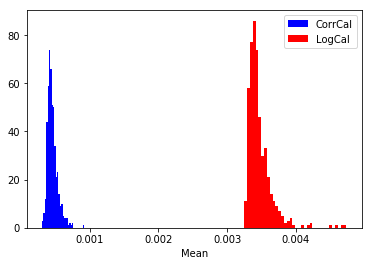

In [19]:
plt.hist(mean,'auto', color = 'b', label = 'CorrCal') 
plt.hist(mean_logcal, 'auto', color = 'r', label = 'LogCal')
plt.xlabel('Mean')
#plt.xscale('log')
plt.legend()
plt.show()

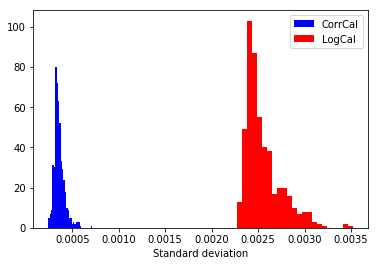

In [21]:
plt.hist(std,'auto', color = 'b', label = 'CorrCal') 
plt.hist(std_logcal, 'auto', color = 'r', label = 'LogCal')
plt.xlabel('Standard deviation')
#plt.xscale('log')
plt.legend()
plt.show()